# Projet Bigdata 2021-2022 
## GDELT : Les événements marquants de l’année 2021

Pierre Dal Bianco \
Aurélien Kouadio \
Jia Liao \
Pooran Shahdi \
Philéas Samir \
Gwladys Sanchez

In [5]:
import pandas as pd
from cassandra.cluster import Cluster, ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import time

In [6]:
profile = ExecutionProfile(consistency_level=ConsistencyLevel.LOCAL_QUORUM)

cluster = Cluster(['tp-hadoop-2'], execution_profiles={EXEC_PROFILE_DEFAULT: profile}) #node
session = cluster.connect('production') #keyspace

In [7]:
!nodetool status

Datacenter: dc1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address        Load       Tokens       Owns (effective)  Host ID                               Rack
UN  192.168.3.41   2.44 GiB   256          47.7%             f99bbe8b-9f0a-4600-b3c2-1dd15dd7153b  rack1
UN  192.168.3.250  2.15 GiB   256          45.9%             4928bb7c-0407-4613-8e9b-fc36f7e37972  rack1
UN  192.168.3.90   1.69 GiB   256          51.1%             ca36896f-65a1-4486-b71f-b228cb1b5d75  rack1
UN  192.168.3.179  2.32 GiB   256          51.4%             a211c6ab-aac0-44fa-8e11-5af269ec63f7  rack1
UN  192.168.3.99   2 GiB      256          52.1%             bb43daa1-8701-412c-91fe-716ddec383bb  rack1
UN  192.168.3.134  607.46 MiB  256          51.8%             7aa8810c-99e0-4ba0-b131-3530133bbf70  rack1



**Question a.** afficher le nombre d’articles par événement qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).

In [8]:
# nb d'articles par événement pour triplet jour et langue de l'article, pays de l'événement)

time0 = time.time()
pays = "FR"
query_a1 = session.execute(f"SELECT jour_event, pays, langue, total FROM table_ab WHERE pays='{pays}';")
data_a1 = pd.DataFrame(query_a1)

print(time.time() - time0, "s")
data_a1.head()

21.46346688270569 s


,jour_event,pays,langue,total
0,20210101,FR,eng,45
1,20210101,FR,rus,2
2,20210101,FR,ita,12
3,20210101,FR,eng,5
4,20210101,FR,eng,5


In [9]:
# nb d'articles par événement pour triplet jour et pays de l'événement, langue de l'article)
time0 = time.time()

pays = "FR"
query_a2 = session.execute(f"SELECT pays, jour_event, langue, SUM(total) \
                           FROM table_ab \
                           WHERE pays='{pays}' \
                           GROUP BY event_id, annee_event, mois_event, jour_event, \
                           annee_mention, mois_mention, jour_mention;")
data_a2 = pd.DataFrame(query_a2)
print(time.time() - time0, "s")

data_a2.head()

20.71639609336853 s


,pays,jour_event,langue,system_sum_total
0,FR,20210101,eng,45
1,FR,20210101,rus,2
2,FR,20210101,ita,12
3,FR,20210101,eng,5
4,FR,20210101,eng,5


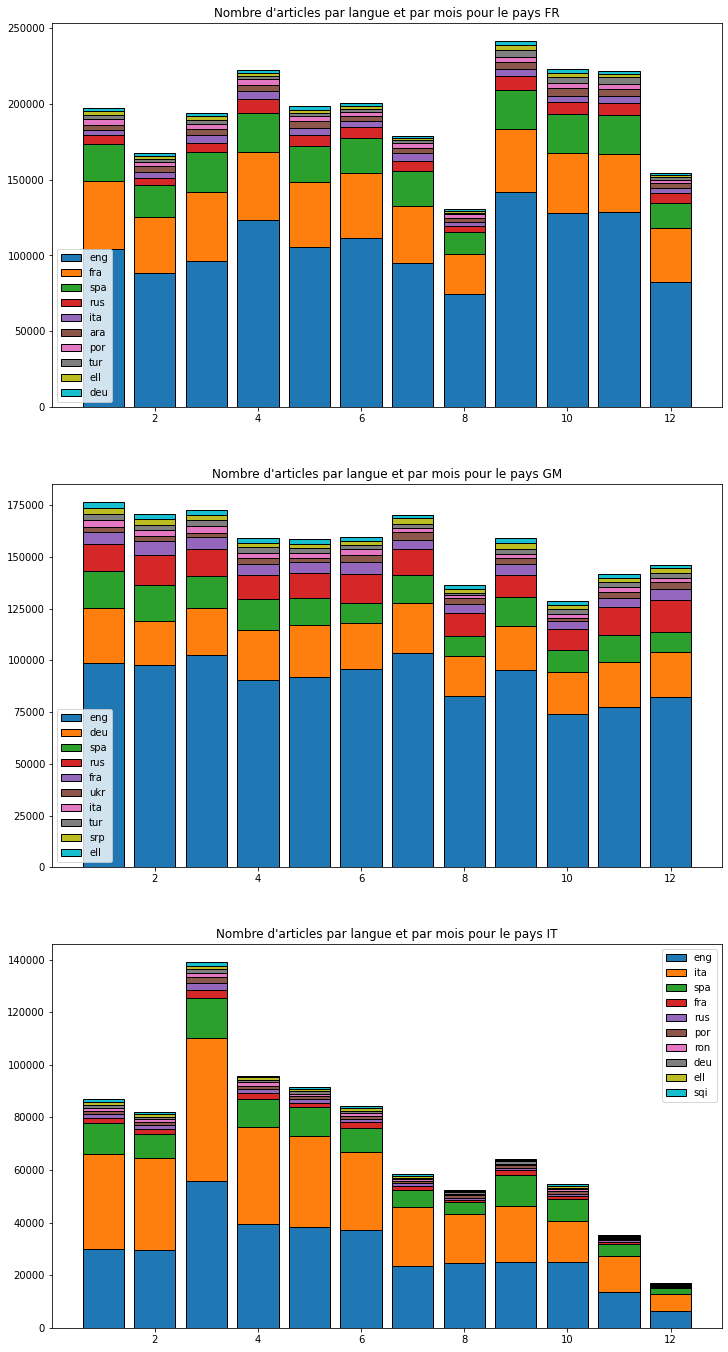

In [6]:
# stacked bar pour un pays 
# Pour un pays en entrée, afficher mois par mois le nb d'article par langue
fig = plt.figure(figsize=(12,24))
for i, pays in enumerate(["FR","GM","IT"]):
    query_a1 = session.execute(f"SELECT pays, jour_mention, langue, total FROM table_ab WHERE pays='{pays}';")
    df = pd.DataFrame(query_a1)
    most_freq_lang = df.groupby("langue").sum().sort_values("total", ascending=False).head(10).index.to_list()
    #print(most_freq_lang)
    df["mois"] = pd.to_datetime(df["jour_mention"], format="%Y%m%d").dt.month
    df = df[df["langue"].apply(lambda x: x in most_freq_lang)].groupby(["mois", "langue"]).sum().reset_index()
    #display(df.head())

    fig.add_subplot(3,1,i+1)
    bottom = np.zeros((12,))
    for l in most_freq_lang:
        plt.bar(df[df["langue"]==l]["mois"],df[df["langue"]==l]["total"],label=l,edgecolor="black",bottom=bottom)
        bottom += df[df["langue"]==l]["total"].to_list()
    plt.legend()
    plt.title("Nombre d'articles par langue et par mois pour le pays "+ pays)
plt.show()

**Question b.** pour un pays donné en paramètre, affichez les évènements qui y ont eu lieu triés par le nombre de mentions (tri décroissant); permettez une agrégation par jour/mois/année

In [10]:
pays = 'FR'
agregation = 'annee_event, mois_event, jour_event, annee_mention, mois_mention, jour_mention' # 'annee, mois' ou 'annee, mois, jour'

time0 = time.time()
query_b = session.execute(
    f"""SELECT event_id, SUM(total) as compte, {agregation}
    FROM table_ab
    WHERE pays = '{pays}'
    GROUP BY event_id, {agregation};""")
data_b = pd.DataFrame(query_b).sort_values("compte", ascending=False)
print(time.time() - time0, "s")

data_b.head()

22.995437383651733 s


,event_id,compte,annee_event,mois_event,jour_event,annee_mention,mois_mention,jour_mention
53251,965262058,544,2021,202101,20210120,2021,202101,20210120
53249,965261780,544,2021,202101,20210120,2021,202101,20210120
53257,965262384,486,2021,202101,20210120,2021,202101,20210120
56513,965419932,462,2021,202101,20210121,2021,202101,20210121
53250,965261781,458,2021,202101,20210120,2021,202101,20210120


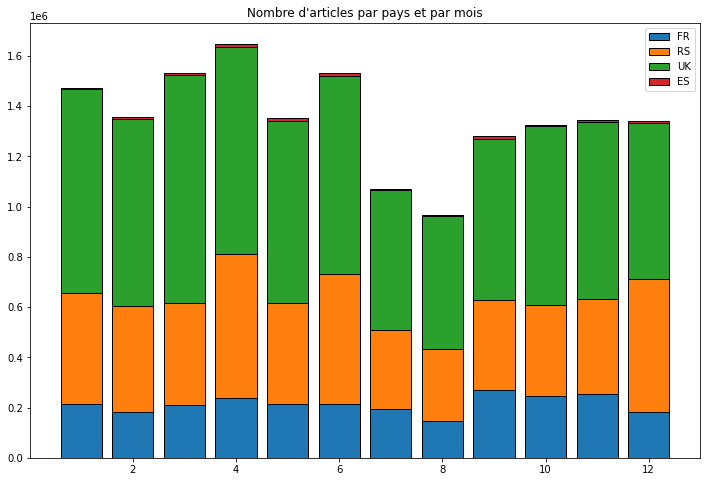

In [8]:
"""
Pour chaque mois de l'année, classer les pays par nombre de mentions total # LONG
"""
agregation = 'annee_event, mois_event, jour_event, annee_mention, mois_mention, jour_mention' 

fig = plt.figure(figsize=(12,8))
bottom = np.zeros((12,))
    
for pays in ["FR","RS","UK","ES"]:
    
    query_b = session.execute(
    f"""SELECT event_id, SUM(total) as compte, {agregation}
    FROM table_ab
    WHERE pays = '{pays}'
    GROUP BY event_id, {agregation};""")
    dfb = pd.DataFrame(query_b) #.sort_values("compte", ascending=False)
    
    dfb["mois"] = pd.to_datetime(dfb["jour_mention"], format="%Y%m%d").dt.month
    
    dfb = dfb[["mois","compte"]].groupby(["mois"]).sum().reset_index()

    plt.bar(dfb["mois"],dfb["compte"],label=pays,edgecolor="black",bottom=bottom)
    bottom += dfb["compte"].to_list()
    
plt.legend()
plt.title("Nombre d'articles par pays et par mois")
plt.show()

**Question c.** pour une source de donnés passée en paramètre (gkg.SourceCommonName) affichez les thèmes, personnes, lieux dont les articles de cette sources parlent ainsi que le nombre d’articles et le ton moyen des articles (pour chaque thème/personne/lieu); permettez une agrégation par jour/mois/année.

In [11]:
source = 'lemonde.fr'
agregation = 'annee, mois, jour' # 'annee', 'annee, mois' ou 'annee, mois, jour'

time0 = time.time()

query_c = session.execute(
    f"""SELECT source, theme, personne, lieu, SUM(total) AS somme_total, SUM(somme_ton)  AS somme_ton, {agregation}
    FROM table_c
    WHERE source = '{source}'
    GROUP BY theme, personne, lieu, {agregation};""")
data_c = pd.DataFrame(query_c).replace("UNK",np.nan).dropna().reset_index(drop=True)
data_c['moyenne_ton'] = data_c['somme_ton'] / data_c['somme_total'] 

print(time.time() - time0, "s")

data_c.head()

0.20216703414916992 s


,source,theme,personne,lieu,somme_total,somme_ton,annee,mois,jour,moyenne_ton
0,lemonde.fr,AFFECT,alexander lukashenko,LG,1,-3.017241,2021,202108,20210829,-3.017241
1,lemonde.fr,AFFECT,amico patrick,FR,1,-4.520796,2021,202109,20210901,-4.520796
2,lemonde.fr,AFFECT,andreano e piccini,BR,1,-2.111761,2021,202101,20210107,-2.111761
3,lemonde.fr,AFFECT,angela merkel,GM,1,-3.791469,2021,202109,20210903,-3.791469
4,lemonde.fr,AFFECT,brigitte bardot,JM,1,-0.478469,2021,202108,20210801,-0.478469


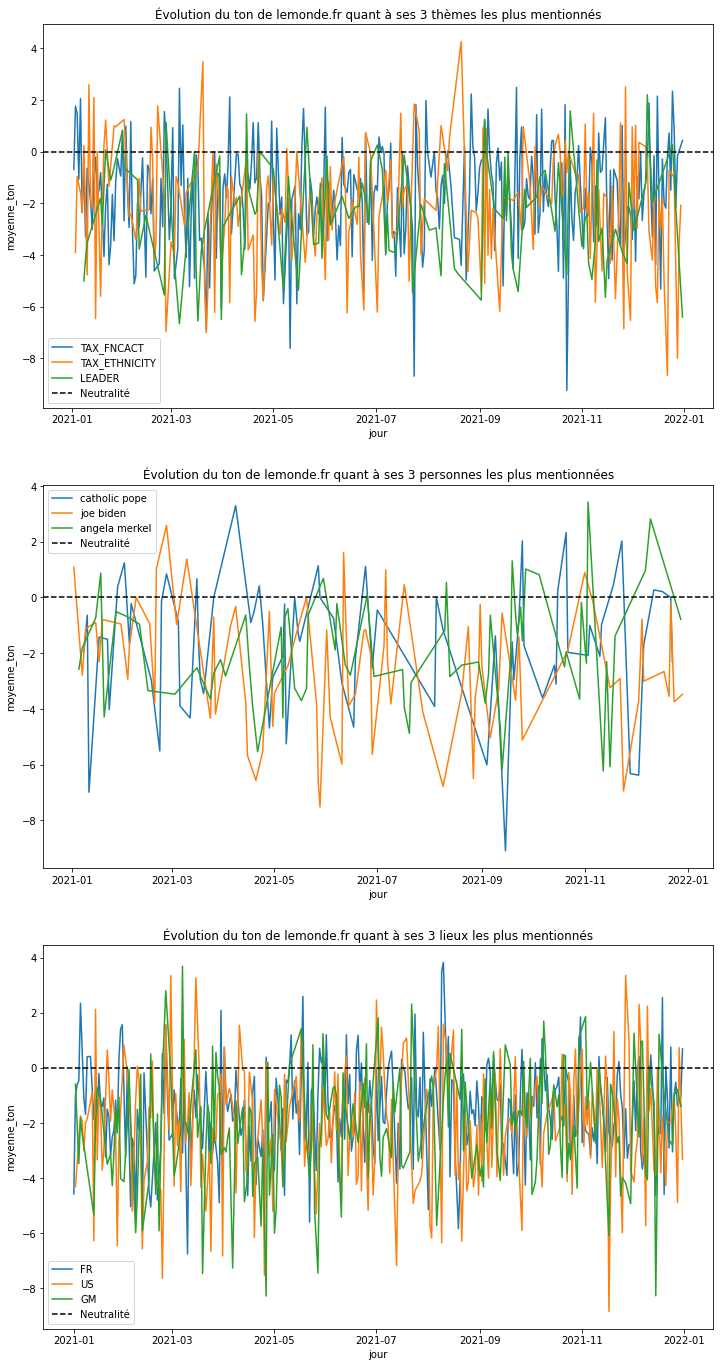

In [10]:
fig = plt.figure(figsize=(12,24))
for i, col in enumerate(["theme","personne","lieu"]):
    ax = fig.add_subplot(3,1,i+1)
    for item in data_c[col].value_counts().index.to_list()[:3]:
        df = data_c[data_c[col]==item]
        sns.lineplot(x=pd.to_datetime(df["jour"], format="%Y%m%d"), y=df["moyenne_ton"], ci=None, label=item, ax=ax)
    ax.axhline(y=0, color="black", linestyle="dashed", label="Neutralité")
    ax.legend()
    if col == "theme":
        ax.set_title(f"Évolution du ton de {source} quant à ses 3 thèmes les plus mentionnés")
    elif col == "personne":
        ax.set_title(f"Évolution du ton de {source} quant à ses 3 personnes les plus mentionnées")
    if col == "lieu":
        ax.set_title(f"Évolution du ton de {source} quant à ses 3 lieux les plus mentionnés")
plt.show()

**Question d.** étudiez l’évolution des relations entre deux pays (spécifiés en paramètre) au cours de l’année. Vous pouvez vous baser sur la langue de l’article, le ton moyen des articles, les thèmes les plus souvent cités, les personnalités ou tout élément qui vous semble pertinent.

Langue du pays == PAYS 1  
Lieu de l'action == PAYS 2

Liste des codes pays : https://fr.wikipedia.org/wiki/Liste_des_codes_de_pays_FIPS_10-4

Exemples intéressants :
- France : FR
- Royaume-Uni : UK
- États-Unis : US
- Russie : RS

In [12]:
time0 = time.time()

langue = 'fra'
lieu = 'TU'
agregation = 'annee, mois, jour' # 'annee, mois' ou 'annee, mois, jour'

query_d = session.execute(
    f"""SELECT langue, lieu, SUM(total) AS somme_total, SUM(somme_ton) AS somme_ton, {agregation}
    FROM table_d
    WHERE langue = '{langue}' AND lieu = '{lieu}'
    GROUP BY {agregation};""")
data_d = pd.DataFrame(query_d)
data_d['moyenne_ton'] = data_d['somme_ton'] / data_d['somme_total'] 
data_d["jour"] = pd.to_datetime(data_d["jour"], format="%Y%m%d")
print(time.time() - time0)
data_d.head()

0.05014348030090332


,langue,lieu,somme_total,somme_ton,annee,mois,jour,moyenne_ton
0,fra,TU,44,-20.936227,2021,202101,2021-01-01,-0.475823
1,fra,TU,25,-66.242885,2021,202101,2021-01-02,-2.649715
2,fra,TU,47,-63.619825,2021,202101,2021-01-03,-1.353613
3,fra,TU,56,-48.117274,2021,202101,2021-01-04,-0.859237
4,fra,TU,84,-88.679429,2021,202101,2021-01-05,-1.055707


In [13]:
time0 = time.time()

langue = 'tur'
lieu = 'FR'
agregation = 'annee, mois, jour' # 'annee, mois' ou 'annee, mois, jour'

query_d_inv = session.execute(
    f"""SELECT langue, lieu, SUM(total) AS somme_total, SUM(somme_ton) AS somme_ton, {agregation}
    FROM table_d
    WHERE langue = '{langue}' AND lieu = '{lieu}'
    GROUP BY {agregation};""")
data_d_inv = pd.DataFrame(query_d_inv)
data_d_inv['moyenne_ton'] = data_d_inv['somme_ton'] / data_d_inv['somme_total'] 
data_d_inv["jour"] = pd.to_datetime(data_d_inv["jour"], format="%Y%m%d")
print(time0 - time.time())
data_d_inv.head()

-0.02279186248779297


,langue,lieu,somme_total,somme_ton,annee,mois,jour,moyenne_ton
0,tur,FR,136,-330.143915,2021,202101,2021-01-01,-2.427529
1,tur,FR,199,-55.011587,2021,202101,2021-01-02,-0.276440
2,tur,FR,144,-273.247225,2021,202101,2021-01-03,-1.897550
3,tur,FR,308,-457.488428,2021,202101,2021-01-04,-1.485352
4,tur,FR,252,-172.703287,2021,202101,2021-01-05,-0.685331


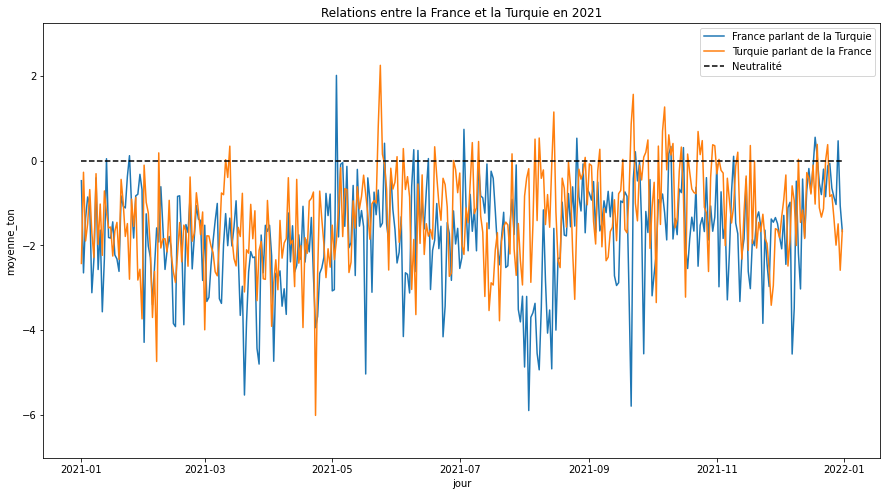

In [25]:
plt.figure(figsize=(15,8))
sns.lineplot(data=data_d, x="jour", y="moyenne_ton", label="France parlant de la Turquie")
sns.lineplot(data=data_d_inv, x="jour", y="moyenne_ton", label="Turquie parlant de la France")
sns.lineplot(data=data_d_inv, x="jour", y=0, linestyle="dashed", label="Neutralité", color="black")
plt.ylim(np.min((data_d["moyenne_ton"].min(), data_d_inv["moyenne_ton"].min()))-1,
         np.max((1, data_d["moyenne_ton"].max()+1, data_d_inv["moyenne_ton"].max()+1)))
plt.title("Relations entre la France et la Turquie en 2021")
plt.show()

### Gestion des pannes

In [14]:
!ssh tp-hadoop-1 sudo service cassandra stop

In [15]:
!nodetool status

Datacenter: dc1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address        Load       Tokens       Owns (effective)  Host ID                               Rack
UN  192.168.3.41   2.44 GiB   256          47.7%             f99bbe8b-9f0a-4600-b3c2-1dd15dd7153b  rack1
UN  192.168.3.250  2.15 GiB   256          45.9%             4928bb7c-0407-4613-8e9b-fc36f7e37972  rack1
UN  192.168.3.90   1.69 GiB   256          51.1%             ca36896f-65a1-4486-b71f-b228cb1b5d75  rack1
UN  192.168.3.179  2.32 GiB   256          51.4%             a211c6ab-aac0-44fa-8e11-5af269ec63f7  rack1
UN  192.168.3.99   2 GiB      256          52.1%             bb43daa1-8701-412c-91fe-716ddec383bb  rack1
DN  192.168.3.134  607.46 MiB  256          51.8%             7aa8810c-99e0-4ba0-b131-3530133bbf70  rack1



In [17]:
pays = 'FR'

query_a1 = session.execute(f"SELECT jour_event, pays, langue, total FROM table_ab WHERE pays='{pays}';")
data_a1_panne = pd.DataFrame(query_a1)

langue = 'fra'
lieu = 'TU'
agregation = 'annee, mois, jour' # 'annee, mois' ou 'annee, mois, jour'

query_d = session.execute(
    f"""SELECT langue, lieu, SUM(total) AS somme_total, SUM(somme_ton) AS somme_ton, {agregation}
    FROM table_d
    WHERE langue = '{langue}' AND lieu = '{lieu}'
    GROUP BY {agregation};""")
data_d_panne = pd.DataFrame(query_d)
data_d_panne['moyenne_ton'] = data_d_panne['somme_ton'] / data_d_panne['somme_total'] 
data_d_panne["jour"] = pd.to_datetime(data_d_panne["jour"], format="%Y%m%d")

print("On a géré la panne :", np.all((data_a1_panne == data_a1).values))
print("On a géré la panne :", np.all((data_d_panne == data_d).values))

On a géré la panne : True
On a géré la panne : True


In [ ]:
# on ferme la session à la fin du fichier
#session.shutdown()

In [11]:
#countries = pd.read_html("https://www.geodatasource.com/resources/tutorials/international-country-code-fips-versus-iso-3166/", header=0)[0]
#countries.to_csv("countries.csv")
countries = pd.read_csv("countries.csv")
countries = dict(zip(countries["FIPS 10-4"], countries["Country name"]))

In [12]:
#lang = pd.read_html("https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes")[0]
#lang.to_csv("lang.csv")
lang = pd.read_csv("lang.csv")
lang["639-2[1]"] = lang["639-2[1]"].apply(lambda x: x.split(" ")[0] if isinstance(x,str) else x)
lang = dict(zip(lang["639-2[1]"], lang["Language name(s) from ISO 639-2[1]"]))

In [14]:
time0 = time.time()

uniques = session.execute("SELECT langue, lieu FROM table_d")
unique_df = pd.DataFrame(uniques)
print("Unique countries :")
unique_places = unique_df["lieu"].to_frame()
unique_places["names"] = unique_places["lieu"].apply(countries.get)
unique_places = unique_places.drop_duplicates().reset_index(drop=True)
display(unique_places)
print()
print("Unique languages :")
unique_lang = unique_df["langue"].to_frame()
unique_lang["names"] = unique_lang["langue"].apply(lang.get)
unique_lang = unique_lang.drop_duplicates().reset_index(drop=True)
display(unique_lang)

Unique countries :


,lieu,names
0,VI,Virgin Islands (British)
1,AS,Australia
2,CI,Chile
3,FI,Finland
4,SP,Spain
...,...,...
257,BV,Bouvet Island
258,FQ,None
259,HQ,None
260,DQ,None



Unique languages :


,langue,names
0,eng,English
1,axe,None
2,spa,Spanish; Castilian
3,srp,Serbian
4,ind,Indonesian
...,...,...
59,mal,Malayalam
60,slv,Slovenian
61,pan,Panjabi; Punjabi
62,afr,Afrikaans
